In [16]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import hmean
    
from tf_lab.fundamentals.utils import set_visible_GPUs, reset_tf_graph

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
import tf_lab.point_clouds.encoders_decoders as enc_dec


import tf_lab.autopredictors.scripts.virt_scan_data as vscan

from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id, points_extension, \
                                                 shape_net_core_synth_id_to_category


from tf_lab.autopredictors.plotting import plot_original_pclouds_vs_reconstructed, \
                                           plot_train_val_test_curves, plot_reconstructions_at_epoch
        
from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs, accuracy_of_completion, \
                                           coverage_of_completion, save_reconstructions, \
                                           save_pc_prediction_stats, save_stats_of_multi_class_experiments, \
                                           paper_pc_completion_experiment_id_best_epoch
                                                  

from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k
from geo_tool import Point_Cloud

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [150]:
GPU = 1
exp_counter = '9'
loss = 'emd'
do_training = False
load_model_conf = True
do_evaluation = True

incomplete_n_samples = 2048
complete_n_samples = 4096

val_percent = .10
dropout_keep_prob = .8
seed = 42

experiment_name = exp_counter + '_all_classes_' + str(incomplete_n_samples) + '_' \
                  + str(complete_n_samples) + 'pts_' + loss

top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'

n_input = [incomplete_n_samples, 3]
n_output = [complete_n_samples, 3] 

train_dir = osp.join(top_data_dir, 'OUT/models/incomplete_pclouds/paper_vanilla_vscan')
train_dir = osp.join(train_dir, experiment_name)
create_dir(train_dir)

max_training_epochs = 100    
max_evaluation_epochs = max_training_epochs

In [6]:
# Load Data of All Classes.
class_to_syn_id = shape_net_category_to_synth_id()
all_classes = vscan.all_classes
n_threads = 50

first = class_to_syn_id[all_classes[0]]
train_data, val_data, test_data = vscan.load_train_val_test_vscan_paper(first, n_threads,\
                                                                        complete_n_samples=complete_n_samples,\
                                                                        incomplete_n_samples=incomplete_n_samples,
                                                                        val_percent=val_percent)
for model_class in vscan.all_classes[1:]:
    class_syn_id = class_to_syn_id[model_class]
    curr_train, curr_val, curr_test = vscan.load_train_val_test_vscan_paper(class_syn_id, n_threads,\
                                                              complete_n_samples=complete_n_samples,\
                                                              incomplete_n_samples=incomplete_n_samples,\
                                                              val_percent=val_percent)
    train_data.merge(curr_train)
    test_data.merge(curr_test)
    val_data.merge(curr_val)

train_data.shuffle_data();

4045 files containing complete point clouds were found.
19800 incomplete point clouds were loaded.
4470 incomplete point clouds were loaded.
1572 files containing complete point clouds were found.
7800 incomplete point clouds were loaded.
1632 incomplete point clouds were loaded.
7497 files containing complete point clouds were found.
29640 incomplete point clouds were loaded.
5922 incomplete point clouds were loaded.
6778 files containing complete point clouds were found.
30000 incomplete point clouds were loaded.
6000 incomplete point clouds were loaded.
2318 files containing complete point clouds were found.
11100 incomplete point clouds were loaded.
2808 incomplete point clouds were loaded.
3173 files containing complete point clouds were found.
15600 incomplete point clouds were loaded.
3438 incomplete point clouds were loaded.
8509 files containing complete point clouds were found.
30000 incomplete point clouds were loaded.
6000 incomplete point clouds were loaded.
1939 files con

In [8]:
print train_data.num_examples + val_data.num_examples
print test_data.num_examples

153540
32304


In [33]:
# # Verification we didn't mix train-test-val data.
# tr = train_data.full_epoch_data(shuffle=False)
# va = val_data.full_epoch_data(shuffle=False)
# te = test_data.full_epoch_data(shuffle=False)

# train_set = set([i[:-6] for i in tr[1]])
# val_set = set([i[:-6] for i in va[1]])
# test_set = set([i[:-6] for i in te[1]])

# c1 = len(test_set.intersection(train_set)) == 0
# c2 = len(test_set.intersection(val_set)) == 0
# c3 = len(train_set.intersection(val_set)) == 0

# assert(c1 and c2 and c3)

# pp = test_data.next_batch(1)
# pinc = pp[2].reshape(incomplete_n_samples, 3)
# pcom = pp[0].reshape(complete_n_samples, 3)
        
# score1 = accuracy_of_completion(pinc, pcom, 0.02, ret_dists=False)
# print score1
# score2, c2 = coverage_of_completion(pcom, pinc, 0.02, ret_dists=True)

# Point_Cloud(points=pinc).plot();
# Point_Cloud(points=pcom).plot(c=c2);
# print pp[1]

In [151]:
tf.set_random_seed(seed)

if load_model_conf:
    conf = Conf.load(osp.join(train_dir, 'configuration'))
    print conf
else:
    decoder_args = {'layer_sizes': [1024, np.prod(n_output)],
                    'non_linearity': tf.nn.relu
                   }

    encoder_args = {'dropout_prob': dropout_keep_prob}
    
    conf = Conf(
                n_input = n_input,
                n_output = n_output,
                denoising = True,
                training_epochs = max_training_epochs,
                batch_size = 50,
                loss = loss,
                train_dir = train_dir,
                loss_display_step = 1,
                saver_step = 1,
                learning_rate = 0.0005,
                encoder = enc_dec.encoder_with_convs_and_symmetry,
                encoder_args = encoder_args,
                decoder = enc_dec.decoder_with_fc_only,
                decoder_args = decoder_args
               )
    
    conf.allow_gpu_growth = False
    conf.experiment_name = experiment_name
    conf.save(osp.join(conf.train_dir, 'configuration'))

conf.consistent_io = None    
reset_tf_graph()
set_visible_GPUs([GPU])
ae = PointNetAutoEncoder(experiment_name, conf)

              allow_gpu_growth: False
                    batch_size: 50
                 consistent_io: False
                         debug: False
                       decoder: decoder_with_fc_only
                  decoder_args: {'non_linearity': <function relu at 0x7f84b2ad4758>, 'layer_sizes': [1024, 12288]}
                       encoder: encoder_with_convs_and_symmetry
                  encoder_args: {'dropout_prob': 0.8}
               experiment_name: 9_all_classes_2048_4096pts_emd
                 gauss_augment: None
                  is_denoising: True
               latent_vs_recon: 1.0
                 learning_rate: 0.0005
                          loss: emd
             loss_display_step: 1
                       n_input: [2048, 3]
                      n_output: [4096, 3]
                           n_z: None
             saver_max_to_keep: None
                    saver_step: 1
                     train_dir: /orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/inc

In [13]:
if do_training:
    training_stats = []
    training_stats.append(ae.train(train_data, conf))    
    with open(osp.join(conf.train_dir, 'train_stats.txt'), 'a') as fout:
        np.savetxt(fout, np.array(training_stats)[0])

In [17]:
if do_evaluation:    
    # Pick the epoch that minimizes the loss on the validation dataset.
    saved_epochs = np.array(read_saved_epochs(conf.train_dir))
    allowable_epochs = saved_epochs[saved_epochs <= max_evaluation_epochs]
    val_stats = eval_model(ae, conf, val_data, epochs=allowable_epochs, verbose=True)
    val_loss = np.min(val_stats[:,1])
    best_epoch = int(val_stats[np.argmin(val_stats[:,1]), 0])
    print 'Best epoch = %d.' % (best_epoch,) 
        
    ae.restore_model(conf.train_dir, best_epoch)
    top_save_dir = osp.join(conf.train_dir, 'output', 'epoch_' + str(best_epoch))
    save_dir = osp.join(top_save_dir, 'test_predictions')
    test_recon, test_loss, test_feed, test_ids, test_gt = ae.evaluate(test_data, conf)
    save_reconstructions(save_dir, test_recon, test_gt, test_feed, test_ids) # save ply files of test data.    
    train_loss = ae.evaluate(train_data, conf)[1]
    
    # Report Accuracy and Coverage of test data.
    n_examples = len(test_recon)
    pred_scores = np.zeros((n_examples, 2))
    for i in xrange(n_examples):
        gt = test_gt[i]
        pred = test_recon[i] 
        pred_scores[i, 0] = accuracy_of_completion(pred, gt, thres=0.02, ret_dists=False)
        pred_scores[i, 1] = coverage_of_completion(gt, pred, thres=0.02, ret_dists=False)
    
    print 'Test Median-Accuracy-Coverage:', np.median(pred_scores[:, 0]), np.median(pred_scores[:, 1])
    
    save_pc_prediction_stats(osp.join(top_save_dir, 'detailed_stats.txt'), test_ids, pred_scores)
    save_stats_of_multi_class_experiments(osp.join(top_save_dir, 'class_stats.txt'), test_ids, pred_scores)
    
    with open(osp.join(top_save_dir, 'stats.txt'), 'w') as fout:
        fout.write('Best Validation Epoch = %d\n' % (best_epoch))
        fout.write('Validation loss = %f\n' % (val_loss))
        fout.write('Train loss = %f\n' % (train_loss))
        fout.write('Test loss = %f\n' % (test_loss))
        fout.write('Gen. Error (abs, per) = %f %f\n' % (abs(test_loss-train_loss),  abs(test_loss-train_loss) / train_loss ))
        fout.write('Test Median-Accuracy-Coverage = %f %f\n' % (np.median(pred_scores[:, 0]), np.median(pred_scores[:, 1])))
        fout.write('Test Median Harmonic Mean = %f' % (np.median(hmean(pred_scores, 1))))

Model restored in epoch 1.
[ 264.4376509]
Model restored in epoch 2.
[ 252.80357428]
Model restored in epoch 4.
[ 239.77965602]
Model restored in epoch 5.
[ 234.79477329]
Model restored in epoch 6.
[ 233.44128752]
Model restored in epoch 7.
[ 229.07569884]
Model restored in epoch 8.
[ 229.2449001]
Model restored in epoch 9.
[ 228.40404024]
Model restored in epoch 10.
[ 228.32410398]
Model restored in epoch 11.
[ 226.75826838]
Model restored in epoch 12.
[ 224.69203361]
Model restored in epoch 13.
[ 224.27484073]
Model restored in epoch 14.
[ 223.96873618]
Model restored in epoch 15.
[ 222.16463735]
Model restored in epoch 16.
[ 225.89498777]
Model restored in epoch 17.
[ 221.63755341]
Model restored in epoch 18.
[ 220.7238685]
Model restored in epoch 19.
[ 222.94362773]
Model restored in epoch 20.
[ 223.73081128]
Model restored in epoch 21.
[ 220.89370246]
Model restored in epoch 22.
[ 222.55593116]
Model restored in epoch 23.
[ 221.64230024]
Model restored in epoch 24.
[ 220.04207875]

# Latent codes:

In [152]:
class_type = 'all_classes'
exp_counter, best_epoch = paper_pc_completion_experiment_id_best_epoch(class_type, loss)
ae.restore_model(conf.train_dir, best_epoch)

In [153]:
from sklearn.manifold import TSNE
from tf_lab.autopredictors.exploration import latent_embedding_of_entire_dataset

feed, latent_emb, ids = latent_embedding_of_entire_dataset(test_data, ae, conf, feed_original=False, apply_augmentation=False)

tokens = [i.split('.') for i in ids]
test_syn_ids = np.array([token[0] for token in tokens], dtype=object)
test_model_names = np.array([token[1] for token in tokens], dtype=object)
test_scan_ids = np.array([token[2] for token in tokens], dtype=object)

# model = TSNE(n_components=2, random_state=seed, init='pca', verbose=True);
# tsne_emb = model.fit_transform(latent_emb)

In [154]:
from tf_lab.autopredictors.scripts.helper import syn_id_to_class_id_dict
from general_tools.arrays.transform import make_contiguous

syn_id_to_cat = shape_net_core_synth_id_to_category
syn_id_to_int = syn_id_to_class_id_dict()
c_int = [syn_id_to_int[i] for i in test_syn_ids]

uvalues = np.unique(c_int)
inv_map = {v: k for k, v in syn_id_to_int.iteritems()}
cc = [syn_id_to_cat[inv_map[u]] for u in uvalues]

# c = make_contiguous(c)

# plt.scatter(tsne_emb[:,0], tsne_emb[:,1], c=c, marker='o')

# cbar = plt.colorbar(ticks=range(0,9))

# cbar.set_ticklabels(cc)
# plt.grid()
# plt.suptitle('TSNE of Test Data (8-Classes).')

In [155]:
samples_per_class = 100
selected = []
for class_id in np.unique(test_syn_ids):
    in_class = np.where(test_syn_ids == class_id)[0]
    selected += np.ndarray.tolist(np.random.choice(in_class, samples_per_class, replace=False))


exemplars = np.array(selected)
latent_emb_small = latent_emb[exemplars]
model = TSNE(n_components=2, random_state=seed, init='pca', verbose=True);
tsne_emb_small = model.fit_transform(latent_emb_small)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 800 / 800
[t-SNE] Mean sigma: 0.526402
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.653676
[t-SNE] Error after 175 iterations: 0.653676


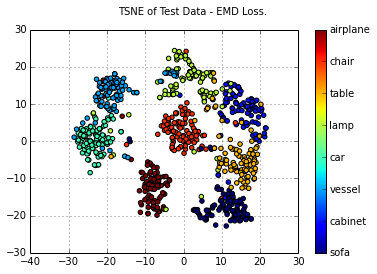

In [157]:
c = np.array(c_int)[exemplars]
c = make_contiguous(c)
plt.scatter(tsne_emb_small[:,0], tsne_emb_small[:,1], c=c)
cbar = plt.colorbar(ticks=range(0,9))
cbar.set_ticklabels(cc)
plt.grid()
plt.suptitle('TSNE of Test Data - EMD Loss.')